# Gene Interacts Gene Edge Prediction

This notebook is designed to take the next step moving from predicted sentences to edge predictions. After training the discriminator model, each sentences contains a confidence score for the likelihood of mentioning a relationship. Multiple relationships contain multiple sentences, which makes establishing an edge unintuitive. Is taking the max score appropiate for determining existence of an edge? Does taking the mean of each relationship make more sense? The answer towards these questions are shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

sys.path.append(os.path.abspath('../../../modules'))

from utils.notebook_utils.dataframe_helper import mark_sentence

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

In [4]:
GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])

In [5]:
total_candidates_df = (
    pd
    .read_table("input/all_gig_candidates.tsv.xz")
    .sort_values("candidate_id")
)
total_candidates_df.head(2)

/home/danich1/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank,candidate_id,sentence_id,text,sen_length
23312106,2796,GNRH1,2796,GNRH1,NaN,9310,0,1,3,0.415835,25627,274809,Correlation between leuteinizing hormone respo...,21
7163244,3976,LIF,3976,LIF,NaN,2732,0,1,3,0.117900,25628,622251,The production of heterologous antibodies to t...,18


In [6]:
sentence_prediction_df = (
    pd
    .read_table("input/all_predicted_gig_sentences.tsv.xz")
    .sort_values("candidate_id")
)
sentence_prediction_df.head(2)

,candidate_id,pred
0,25627,0.023143
1,25628,0.000479


In [7]:
# DataFrame that combines likelihood scores with each candidate sentence
total_candidates_pred_df = (
    total_candidates_df[[
    "gene1_id", "gene1_name", 
    "gene2_id", "gene2_name", 
    "text", "hetionet",
    "candidate_id", "split"
    ]]
    .merge(sentence_prediction_df, on="candidate_id")
)

#total_candidates_pred_df.to_csv(
#    "output/combined_predicted_gig_sentences.tsv.xz", 
#    sep="\t", index=False, compression="xz"
#)

total_candidates_pred_df.head(2)

,gene1_id,gene1_name,gene2_id,gene2_name,text,hetionet,candidate_id,split,pred
0,2796,GNRH1,2796,GNRH1,Correlation between leuteinizing hormone respo...,0,25627,3,0.023143
1,3976,LIF,3976,LIF,The production of heterologous antibodies to t...,0,25628,3,0.000479


In [8]:
# DataFrame that groups gene mentions together and takes
# the max, median and mean of each group
grouped_candidates_pred_df=(
    total_candidates_pred_df
    .groupby(["gene1_id", "gene2_id"], as_index=False)
    .agg({
        "pred": ['max', 'mean', 'median'], 
        'hetionet': 'max',
        "gene1_name": 'first',
        "gene2_name": 'first',
        "split": 'first'
    })
)
grouped_candidates_pred_df.head(2)

gene1_id gene2_id      pred                     hetionet gene1_name  \
                          max      mean    median      max      first   
0        1        1  0.640881  0.134423  0.110034        0       A1BG   
1        1        2  0.127734  0.080726  0.080726        0       A1BG   

  gene2_name split  
       first first  
0       A1BG     4  
1        A2M     3

In [9]:
grouped_candidates_pred_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene1_name', 'gene2_name', 'split'] else col[0] 
    for col in grouped_candidates_pred_df.columns.values
]
grouped_candidates_pred_df.head(2)

,gene1_id,gene2_id,pred_max,pred_mean,pred_median,hetionet,gene1_name,gene2_name,split
0,1,1,0.640881,0.134423,0.110034,0,A1BG,A1BG,4
1,1,2,0.127734,0.080726,0.080726,0,A1BG,A2M,3


In [10]:
grouped_candidates_pred_subet_df = (
    grouped_candidates_pred_df
    .query("split==5")
    .drop("split", axis=1)
)
grouped_candidates_pred_subet_df.head(2)

,gene1_id,gene2_id,pred_max,pred_mean,pred_median,hetionet,gene1_name,gene2_name
8,1,207,0.120141,0.120141,0.120141,0,A1BG,AKT1
45,1,3043,0.079925,0.079925,0.079925,0,A1BG,HBB


In [11]:
grouped_candidates_pred_subet_df.hetionet.value_counts()

0    141875
1      3553
Name: hetionet, dtype: int64

# Best Sentence Representation Metric

This section aims to answer the question: What metric (Mean, Max, Median) best predicts Hetionet Edges?

In [12]:
performance_map = {}

In [13]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_max,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_max,
)

performance_map['max'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [14]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_mean,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_mean,
)

performance_map['mean'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [15]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_median,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_median,
)

performance_map['median'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

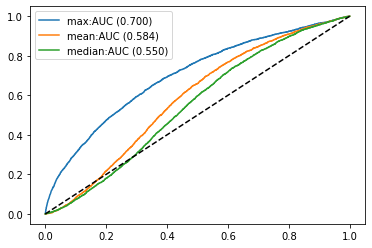

In [16]:
for key in performance_map:
    plt.plot(
        performance_map[key]['false_pos'], 
        performance_map[key]['true_pos'], 
        label=f"{key}:AUC ({auc(performance_map[key]['false_pos'], performance_map[key]['true_pos']):.3f})"
    )
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.legend()
plt.show()

/home/danich1/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


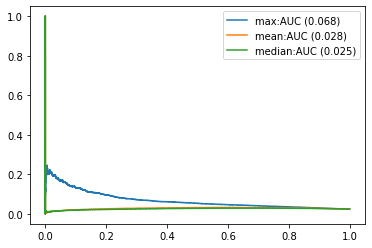

In [17]:
for key in performance_map:
    plt.plot(
        performance_map[key]['recall'], 
        performance_map[key]['precision'], 
        label=f"{key}:AUC ({auc(performance_map[key]['recall'], performance_map[key]['precision']):.3f})"
    )

plt.legend()
plt.show()

# Optimal Cutoff Using PR-CURVE 

In [18]:
threshold_df = (
    pd.DataFrame(
        list(
            zip(
                performance_map['max']['precision'], 
                performance_map['max']['recall'], 
                performance_map['max']['pr_threshold']
            )
        ),
        columns=["precision", "recall", "pr_threshold"]
    )
    .sort_values("precision", ascending=False)
)
threshold_df.head(2)

,precision,recall,pr_threshold
144615,0.247059,0.00591,0.906598
144614,0.244186,0.00591,0.906542


In [19]:
#precision_thresholds = pd.np.linspace(0,1,num=5)
precision_thresholds = threshold_df.round(2).drop_duplicates("precision").precision.values

# Add the lowest precision rather than
# Keep it zero
precision_thresholds = (
    pd.np.where(
        precision_thresholds==0, 
        threshold_df.query("precision > 0").precision.min(), 
        precision_thresholds
    )
)

performance_records = []
for precision_cutoff in precision_thresholds:

    cutoff = (
        threshold_df
        .query("precision>=@precision_cutoff")
        .pr_threshold
        .min()
    )
    
    values_added = (
        grouped_candidates_pred_df
        .query("pred_max >= @cutoff")
        .hetionet
        .value_counts()
    )
    
    series_keys = list(values_added.keys())
    for key in series_keys:
        performance_records.append(
           {  
               "edges": values_added[key], 
               "in_hetionet": "Existing" if key == 1 else "Novel", 
               "precision": precision_cutoff,
               "sen_cutoff": cutoff
           }
        )
   
    
edges_added_df = (
    pd
    .DataFrame
    .from_records(performance_records)
)
edges_added_df.head(10)

,edges,in_hetionet,precision,sen_cutoff
0,2667,Novel,0.24,0.904872
1,825,Existing,0.24,0.904872
2,3447,Novel,0.23,0.897830
3,993,Existing,0.23,0.897830
4,7253,Novel,0.22,0.875078
5,1683,Existing,0.22,0.875078
6,10192,Novel,0.21,0.862549
7,2148,Existing,0.21,0.862549
8,12265,Novel,0.20,0.855129
9,2446,Existing,0.20,0.855129


[None]

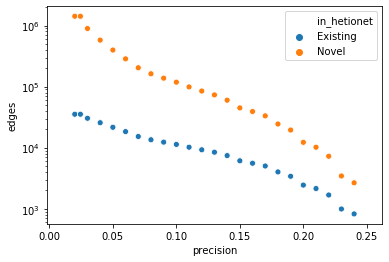

In [20]:
ax = sns.scatterplot(x="precision", y="edges", hue="in_hetionet", data=edges_added_df.sort_values("in_hetionet"))
ax.set(yscale="log")

In [21]:
edges_added_df.to_csv("output/precision_gig_edges_added.tsv", index=False, sep="\t")

# Total Recalled Edges

How many edges of hetionet can we recall using a cutoff score of 0.5?

In [22]:
def tag_sentence(x):
    candidates=(
        session
        .query(GeneGene)
        .filter(GeneGene.id.in_(x.candidate_id.astype(int).tolist()))
        .all()
    )
    tagged_sen=[
         " ".join(
             mark_sentence(
                candidate_to_tokens(cand), 
                [
                        (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                        (cand[1].get_word_start(), cand[1].get_word_end(), 2)
                ]
            )
         )
        for cand in candidates
    ]

    return tagged_sen

In [23]:
gen_pred_df = (
    pd.read_csv("../label_sampling_experiment/results/GiG/marginals/train/28_sampled_train.tsv.xz", sep="\t")
    .iloc[:, [0,-1]]
    .append(
        pd.read_csv("../label_sampling_experiment/results/GiG/marginals/tune/28_sampled_dev.tsv", sep="\t")
        .iloc[:, [0,-1]]
    )
    .append(
        pd.read_csv("../label_sampling_experiment/results/GiG/marginals/test/28_sampled_test.tsv", sep="\t")
        .iloc[:, [0,-1]]
    )
)
gen_pred_df.columns = ["gen_pred", "candidate_id"]
gen_pred_df.head(2)

,gen_pred,candidate_id
0,1.943307e-05,25627
1,1.260264e-08,25628


In [24]:
(
    total_candidates_pred_df.iloc[
        total_candidates_pred_df
        .groupby(["gene1_id", "gene2_id"], as_index=False)
        .agg({
            "pred": 'idxmax'
        })
        .pred
    ]
    .merge(gen_pred_df, on=["candidate_id"])
    .assign(edge_type="GiG")
    .sort_values("pred", ascending=False)
    .query("gene1_name!=gene2_name")
    .head(10)
    .sort_values("candidate_id")
    .assign(text=lambda x: tag_sentence(x))
    .merge(total_candidates_df[["n_sentences", "candidate_id"]], on="candidate_id")
    .sort_values("pred", ascending=False)
    .assign(hetionet=lambda x: x.hetionet.apply(lambda x: "Existing" if x == 1 else "Novel"))
    [["edge_type", "gene1_name", "gene2_name", "gen_pred", "pred", "n_sentences", "hetionet", "text"]]
    .to_csv("output/top_ten_edge_predictions.tsv", sep="\t", index=False, float_format="%.3g")
)

In [25]:
datarows = []
fpr, tpr, threshold = roc_curve(
    grouped_candidates_pred_df.hetionet.values, 
    grouped_candidates_pred_df.pred_max.values
)

fnr = 1 - tpr
optimal_threshold = threshold[pd.np.nanargmin(pd.np.absolute((fnr - fpr)))]

datarows.append({
    "recall":(
        grouped_candidates_pred_df
        .query("pred_max > @optimal_threshold")
        .hetionet
        .value_counts()[1] /
        grouped_candidates_pred_df
        .hetionet.
        value_counts()[1]
    ),
    "edges":(
        grouped_candidates_pred_df
        .query("pred_max > @optimal_threshold")
        .hetionet
        .value_counts()[1]
    ),
    "in_hetionet": "Existing",
    "total": int(grouped_candidates_pred_df.hetionet.value_counts()[1]),
    "relation":"GiG"
})
datarows.append({
    "edges":(
        grouped_candidates_pred_df
        .query("pred_max > @optimal_threshold")
        .hetionet
        .value_counts()[0]
    ),
    "in_hetionet": "Novel",
    "relation":"GiG"
})
edges_df = pd.DataFrame.from_records(datarows)
edges_df

,recall,edges,in_hetionet,total,relation
0,0.665357,23537,Existing,35375.0,GiG
1,NaN,476102,Novel,NaN,GiG


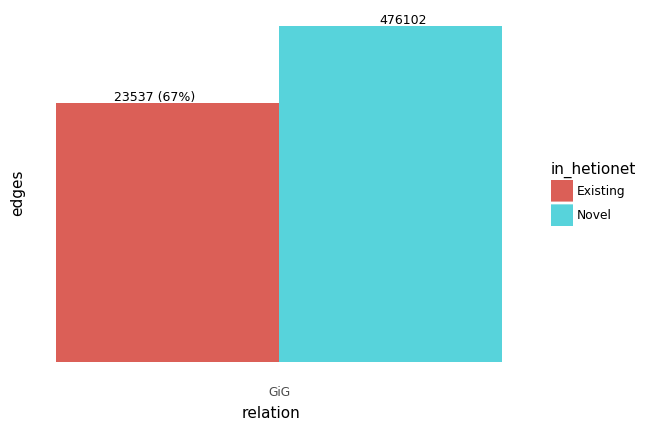

<ggplot: (8770147601044)>


In [26]:
import math
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df
                .apply(
                    lambda x: 
                    f"{x['edges']} ({x['recall']*100:.0f}%)" 
                    if not math.isnan(x['recall']) else 
                    f"{x['edges']}",
                    axis=1
                )
            )
        ),
        position=p9.position_dodge(width=1),
        size=9,
        va="bottom"
    )
    + p9.scale_y_log10()
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major = p9.element_blank(),
        rect=p9.element_blank()
    )
)
print(g)